### 通过微调遵循人类指令

#### 7.2为有监督指令微调准备数据集

下载数据，保存到本地，并且加载为JSON格式

In [19]:
import json
import os
import urllib
import urllib.request

file_path = "instruction-data.json"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch07/01_main-chapter-code/instruction-data.json"

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w") as file:
            file.write(text_data)
    else:
        with open(file_path, "r") as file:
            text_data = file.read()

            
    return json.loads(text_data)
    

data = download_and_load_file(file_path=file_path, url=url)

print(f"The data length is: {len(data)}")
print(f"Example entry:\n {json.dumps(data[0], indent=4)}")

The data length is: 1100
Example entry:
 {
    "instruction": "Evaluate the following phrase by transforming it into the spelling given.",
    "input": "freind --> friend",
    "output": "The spelling of the given phrase \"freind\" is incorrect, the correct spelling is \"friend\"."
}


In [20]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task."
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    
    input_text = (
        f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    )
    
    return instruction_text + input_text

def format_response(entry):
    return f"\n\n### Response:\n{entry['output']}"

entry = data[500]
model_input = format_input(entry)
desired_response = format_response(entry)

print(model_input + desired_response)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Translate 'Thank you very much' into Japanese.

### Response:
The Japanese translation of 'Thank you very much' is 'どうもありがとうございます' (Dōmo arigatōgozaimasu).


In [21]:
def create_data(data, train_rate=0.85, test_rate=0.1):
    data_len = len(data)
    train_portion = int(data_len * train_rate)
    test_portion = int(data_len * test_rate)
    
    validation_portion = train_portion + test_portion

    
    return data[:train_portion], data[train_portion:validation_portion], data[validation_portion:]

train_data, test_data, val_data = create_data(data=data)

print("Train length", len(train_data))
print("Validation length", len(val_data))
print("Test length", len(test_data))

Train length 935
Validation length 55
Test length 110


#### 7.3将数据组织成训练批次

In [22]:
import torch
from torch.utils.data import Dataset
import tiktoken

# 格式化指令，并且转成token_ids
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        
        for entry in self.data:
            input_text = format_input(entry)
            response_text = format_response(entry)
            
            self.encoded_texts.append(
                tokenizer.encode(input_text + response_text)
            )    
        
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)
    
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [23]:
def custom_collate_draft_1(batch, pad_token=50256, device="cpu"):
    max_length = max(len(item) + 1 for item in batch)
    token_list = []
    
    for item in batch:
        new_item = item.copy()
        
        token_list.append(
            torch.tensor((new_item + [pad_token] * (max_length - len(new_item)))[:-1])
        )
    
    return torch.stack(token_list).to(device)

def custom_collate_draft_2(batch, pad_token=50256, device="cpu"):
    max_length = max(len(item) + 1 for item in batch)
    input_list, target_list = [], []
    
    for item in batch:
        new_item = item.copy()
        padded = new_item + [pad_token] * (max_length - len(new_item))
        
        input_tensor = torch.tensor(padded[:-1])
        target_tensor = torch.tensor(padded[1:])
        
        input_list.append(input_tensor)
        target_list.append(target_tensor)
    
    return torch.stack(input_list).to(device), torch.stack(target_list).to(device)
    


inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [4, 5]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)    
    
print(custom_collate_draft_1(batch))

input, target = custom_collate_draft_2(batch)
print(input)
print(target)

tensor([[    0,     1,     2,     3,     4],
        [    4,     5, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    0,     1,     2,     3,     4],
        [    4,     5, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    5, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [24]:
def custom_collate_fn(
    batch, pad_token=50256, ignore_index = -100, allow_max_length = None, device="cpu"
):
    max_length = max(len(item) + 1 for item in batch)
    input_list, target_list = [], []
    
    for item in batch:
        new_item = item.copy()
        padded = new_item + [pad_token] * (max_length - len(new_item))
        
        input_tensor = torch.tensor(padded[:-1])
        target_tensor = torch.tensor(padded[1:])
        
        mask = target_tensor == pad_token
        indices = torch.nonzero(mask).squeeze()
        
        if indices.numel() > 1:
            target_tensor[indices[1:]] = ignore_index
            
        if allow_max_length is not None:
            input_tensor = input_tensor[:allow_max_length]
            target_tensor = target_tensor[:allow_max_length]
        
        
        input_list.append(input_tensor)
        target_list.append(target_tensor)
    
    return torch.stack(input_list).to(device), torch.stack(target_list).to(device)


inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [4, 5]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

input, target = custom_collate_fn(batch)
print(input)
print(target)

tensor([[    0,     1,     2,     3,     4],
        [    4,     5, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    5, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


#### 7.4 创建指令数据集的数据加载器

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
#     device = torch.device("mps")
    
print(f"Device {device}")

from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allow_max_length=1024
)

Device cpu


In [26]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
val_dataset = InstructionDataset(val_data, tokenizer)
test_dataset = InstructionDataset(test_data, tokenizer)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print("Train loader\n")

for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader

torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

#### 7.5 加载预训练大语言模型

In [27]:
import json
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

CHOOSE_MODEL = "gpt2-medium (355M)"
INPUT_PROMPT = "Every effort moves"
BASIC_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASIC_CONFIG.update(model_configs[CHOOSE_MODEL])

formatted_basic_config = json.dumps(BASIC_CONFIG, indent=4)

print(formatted_basic_config)

model_size = CHOOSE_MODEL.split(' ')[-1].lstrip("(").rstrip(")")

print(model_size)

setting, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASIC_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

{
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": true,
    "emb_dim": 1024,
    "n_layers": 24,
    "n_heads": 16
}
355M
File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


In [28]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [29]:
from previous_chapters import generate, text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer=tokenizer),
    max_new_tokens=35,
    context_size=BASIC_CONFIG['context_length'],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

response_text = generated_text[len(input_text):].strip()

print(response_text)

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Instruction:

Convert the active


#### 7.6 在指令数据上微调大语言模型

In [30]:
from previous_chapters import calc_loss_loader, train_model_simple
import time

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader,
        model=model,
        device=device,
        num_batches=5
    )
    val_loss = calc_loss_loader(
        val_loader,
        model=model,
        device=device,
        num_batches=5
    )
    
print("Train loss:", train_loss)
print("Validation loss:", val_loss)

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time = (end_time - start_time) / 60

print(f"Training completed in {execution_time:.2f} minutes.")

Train loss: 4.013538599014282
Validation loss: 3.938512849807739
Ep 1 (Step 000000): Train loss 2.776, Val loss 2.755
Ep 1 (Step 000005): Train loss 1.207, Val loss 1.138
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.968
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.907
Ep 1 (Step 000020): Train loss 0.788, Val loss 0.910
Ep 1 (Step 000025): Train loss 0.775, Val loss 0.866
Ep 1 (Step 000030): Train loss 0.801, Val loss 0.841
Ep 1 (Step 000035): Train loss 0.716, Val loss 0.813
Ep 1 (Step 000040): Train loss 0.669, Val loss 0.803
Ep 1 (Step 000045): Train loss 0.634, Val loss 0.792
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.785
Ep 1 (Step 000055): Train loss 0.763, Val loss 0.772
Ep 1 (Step 000060): Train loss 0.721, Val loss 0.749
Ep 1 (Step 000065): Train loss 0.651, Val loss 0.739
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.731
Ep 1 (Step 000075): Train loss 0.566, Val loss 0.732
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.723
Ep 1 (Step 000085): Train loss 0.5

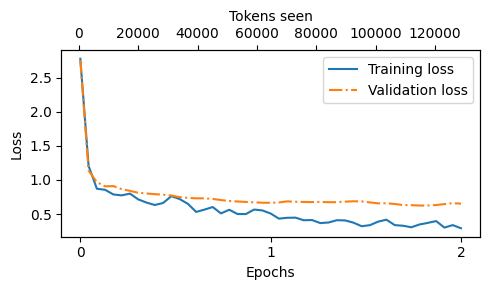

In [31]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#### 7.7 抽取并保存模型回复

In [32]:
torch.manual_seed(123)

for entry in test_data[:3]:
    input_text = format_input(entry)
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASIC_CONFIG["context_length"],
        eos_id=50256
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    
    print(f"Input text:\n {input_text}")
    print(f"\nCorrect output\n {entry['output']}")
    print(f"\nModel response\n {response_text}")

Input text:
 Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct output
 The car is as fast as lightning.

Model response
 The car is as fast as a bullet.
Input text:
 Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct output
 The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response
 The type of cloud associated with thunderstorms is a cumulus cloud.
Input text:
 Below is an instruction that describes a task.Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct output
 Jane Austen.

Model response
 The author of 'Pride and Prejudice' is Jane Austen.


In [33]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
    
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer),
        max_new_tokens=256,
        context_size=BASIC_CONFIG['context_length'],
        eos_id=50256
    )
    
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    
    test_data[i]["model_response"] = response_text
    
with open("instruction-data-with-response.json", "w") as f:
    json.dump(test_data, f, indent=4)

100%|██████████| 110/110 [06:47<00:00,  3.70s/it]


In [35]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-sft.pth"

torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-sft.pth


#### 7.8 评估微调后的大语言模型

In [36]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

print("Ollama running:", ollama_running)

Ollama running: True


In [37]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "messages": [{
            "role": "user",
            "content": prompt
        }],
        "options": {
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }
    
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    
    request.add_header("Content-Type", "application/json")
    
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    return response_data
    

result = query_model("What do Llamas eat?")
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [38]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score."
    )
    
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than using lightning (which is often associated with speed and power). However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

-------------------------

Dataset response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunders

In [43]:
def generate_model_scores(json_data, json_key="model_response", model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Only output the integer of the final answer; do not include any text, symbols, or explanations."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            
    return scores

scores = generate_model_scores(test_data)

print("Score length: ", len(scores))
print("Data length:", len(test_data))

print(f"Average score: {(sum(scores) / len(scores)):.2f}")

Scoring entries: 100%|██████████| 110/110 [00:45<00:00,  2.43it/s]

Score length:  110
Data length: 110
Average score: 48.94
